# Aula 4 - Aprendizado de Máquina - Tutoria

Saulo Martiello Mastelini (mastelini@usp.br)</br>
Outras redes: [Github](https://github.com/smastelini) - [Linkedin](https://www.linkedin.com/in/smastelini/)

MBA em Ciência de Dados <br>
Universidade de São Paulo, São Carlos, Brasil<br>
Copyright (c) 2021

# 1. Regressão, o patinho feio de Aprendizado de Máquina (e algumas considerações iniciais)

É muito comum vermos aplicações de **aprendizado de máquina** (AM) que lidam com **classificação**. Na verdade, quase todos os exemplos que vemos por aí lidam com classificação. Na própria descrição de algoritmos em seus artigos vemos coisas como: "a extensão dessa técnica para tarefas de regressão é trivial, basta (...)".

Sem problemas até aqui, mas temos que sempre lembrar que **regressão** é uma área de pesquisa tão relevante quanto à regressão. Sendo assim, é de se esperar que tenha várias **particularidades** e detalhes que devem ser bem pensados quando aplicando uma solução. Por exemplo, em classificação temos medidas específicas para dados com desbalanceamento. Em classificação binária também já temos a noção intuitiva que uma acurácia menor do 50% é um indicativo que um nosso modelo de AM está pior do que um preditor aleatório.

Dessa forma, gostaria de discutir algumas particularidades de regressão que aprendi durante meus anos de experiência.

## 1.1 Use métricas de avaliação complementares

Em regressão, algumas métricas de erro sempre estão "na boca do povo":

- Mean Square Error (MSE)
- Root Mean Square Error (RMSE)
- Mean Absolute Error (MAE)
- e por aí vai...

O que elas têm em comum?

- Quanto menor, melhor
- Zero é o mínimo
- Não existe, a princípio, um valor máximo
- Na maioria dos casos, os erros estão na mesma escala do que o target

O melhor erro possível é zero, mas o que seria um erro adequado?

É comum usarmos mais de uma métrica de avaliação para avaliar o desempenho em regressão.

Dica inicial:

**Combine uma ou mais métrica de erro e o coeficiente de determinação (R2)**

In [1]:
# Para fins didáticos, importarei os pacotes a medida que formos precisando deles
import numpy as np
import matplotlib.pyplot as plt

Vamos gerar alguns dados para analisarmos


In [2]:
rng = np.random.default_rng(42)

x = rng.uniform(-5, 5, 100)
x[1:10]

array([-0.6112156 ,  3.5859792 ,  1.97368029, -4.05822652,  4.75622352,
        2.61139702,  2.86064305, -3.71886367, -0.49614062])

In [3]:
y = x ** 2 - 2 * x
y[1:10]

array([ 1.59601572,  5.68728842, -0.05194669, 24.58565554, 13.1092151 ,
        1.59660036,  2.46199257, 21.26767437,  1.23843676])

Vamos supor que construímos um preditor linear para este problema: $\hat{y} = -3x + 10$


In [4]:
y_hat = lambda x: -3 * x + 10

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(x, y, label="Real")
ax.scatter(x, y_hat(x), label="Predito")
ax.legend()

Vamos calcular os erros cometidos usando RMSE:


In [5]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y, y_hat(x), squared=False)

7.429942718046041

Parece alto, não é? Mas e se...

In [55]:
y = (x ** 2 - 2 * x) / 100
y_hat = lambda x: (-3 * x + 10) / 100

mean_squared_error(y, y_hat(x), squared=False)

0.07429942718046041

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(x, y, label="Real")
ax.scatter(x, y_hat(x), label="Predito")
ax.legend()

O nosso modelo continua não capturando bem o comportamento dos dados.

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(y, y_hat(x), label="Resíduo")
ax.set_xlabel("Real")
ax.set_ylabel("Predito")
ax.plot([min(y), max(y)], [min(y), max(y)], c="red", label="y = y")
ax.legend()

In [9]:
from sklearn.metrics import r2_score

r2_score(y, y_hat(x))

0.36338883178156633

Vamos mudar o nosso modelo preditivo:

In [10]:
y = x ** 2 - 2 * x
y_hat = lambda x: x ** 2

r2_score(y, y_hat(x))

0.6572910822237976

In [11]:
r2_score(y, y)

1.0

Outro aspecto legal do R2 é que ele também tem uma espécie de "baseline" embutido. Suponha que criemos um modelo muito simples que sempre prevê a média dos valores:

In [12]:
u = np.mean(y)

y_baseline = np.array([u] * len(y))

r2_score(y, y_baseline)

0.0

Valores menores do que zero implicam que o modelo é pior do que o baseline que sempre prevê a média dos valores.

# 2. Voltemos ao foco: modelos lineares e regularização

Temos três variantes principais de regularização:

- **l1** (LASSO): adiciona um custo extra proporcional à soma dos valores absolutos dos pesos
- **l2** (Ridge): adiciona um custo extra proporcional à some dos quadrados dos pesos
- **Elastic Net**: combina as duas anteriores

São implementados no `sklearn` no módulo `linear_model`:

- `Lasso`
- `Ridge`
- `ElasticNet`

É possível ajustar a quantidade de regularização automaticamente, ao adicionar o sufixo `CV` nas classes. Por exemplo, para ajudar o valor da penalização do Ridge Regression, usamos a classe `RidgeCV`.

Vamos tentar entender como cada um desses modelos se comporta e quando escolher cada um deles.

Iniciaremos com cenários sintéticos.


In [13]:
from sklearn.datasets import make_regression
from sklearn import linear_model
from sklearn.model_selection import train_test_split

## 2.1 Features redundantes

Primeiramente, exploraremos um cenário com features redundantes.

In [14]:
X, y, coef = make_regression(
    n_samples=200, n_features=10, n_informative=3,
    coef=True, noise=1, effective_rank=4, random_state=42
)
coef

array([ 0.        , 13.66009037,  0.        , 65.16397605,  0.        ,
        0.        ,  0.        ,  0.        , 73.85974581,  0.        ])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [16]:
lr = linear_model.LinearRegression(normalize=True)
lr.fit(X_train, y_train)

lr.coef_

array([-0.22055274,  8.48189652, -4.41556727, 70.53278274,  0.45758541,
        2.32710903,  0.22967093,  2.04603794, 73.26365827,  2.16580479])

In [17]:
y_pred = lr.predict(X_test)
f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)} -- R2: {r2_score(y_test, y_pred)}"

'RMSE: 1.016716064634011 -- R2: 0.9580528397487583'

Hora de considerar regularização

In [18]:
lasso = linear_model.LassoCV(alphas=[0.01, 0.02, 0.1, 0.15, 0.2, 0.5, 0.7], random_state=42, normalize=True)
lasso.fit(X_train, y_train)

lasso.coef_, lasso.alpha_

(array([ 0.        ,  7.32922651, -1.22874641, 67.70911219, -0.        ,
         0.37351371,  0.        ,  0.        , 69.91971784,  0.        ]),
 0.01)

In [19]:
y_pred = lasso.predict(X_test)
f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)} -- R2: {r2_score(y_test, y_pred)}"

'RMSE: 1.0553003505903118 -- R2: 0.9548086454771715'

In [20]:
ridge = linear_model.RidgeCV(alphas=[0.01, 0.02, 0.1, 0.15, 0.2, 0.5, 0.7], normalize=True)
ridge.fit(X_train, y_train)

ridge.coef_, ridge.alpha_

(array([ 0.15903052,  8.7306001 , -4.57292201, 69.12010473,  0.3085978 ,
         2.40390253,  0.29857523,  1.1441728 , 72.32639578,  1.80521282]),
 0.01)

In [21]:
y_pred = ridge.predict(X_test)
f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)} -- R2: {r2_score(y_test, y_pred)}"

'RMSE: 1.0141946339070589 -- R2: 0.958260637604702'

In [22]:
en = linear_model.ElasticNetCV(
    l1_ratio=[0.01, 0.1, 0.3, 0.7, 0.8, 0.9, 0.99],
    alphas=[0.01, 0.02, 0.1, 0.15, 0.2, 0.5, 0.7], normalize=True
)

en.fit(X_train, y_train)
en.coef_, en.alpha_, en.l1_ratio_


(array([ 0.        ,  7.50682602, -1.63765274, 66.47420686, -0.        ,
         0.32424188,  0.        , -0.        , 68.81007647,  0.        ]),
 0.01,
 0.99)

In [23]:
y_pred = en.predict(X_test)
f"RMSE: {mean_squared_error(y_test, y_pred, squared=False)} -- R2: {r2_score(y_test, y_pred)}"

'RMSE: 1.0644246910900792 -- R2: 0.9540237999129845'

Em suma:

- LR não consegue remover completamente a relevância das features não-informativas
- LASSO é capaz de fazer seleção de features
- Ridge diminui o peso das features não informativas, mas não zera o valor dos coeficientes
- Elastic Net também é capaz de zerar os coeficientes das features não-informativas (desde que confirgurada para agir de forma semelhante à LASSO)

## 2.2 Features correlacionadas

In [24]:
X, y, coef = make_regression(
    n_samples=200, n_features=3, n_informative=3,
    coef=True, noise=5, random_state=42, effective_rank=2
)
coef

array([15.33514031, 94.72833396, 46.20058036])

In [25]:
X = np.hstack([X, X])
X.shape

(200, 6)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [27]:
lr = linear_model.LinearRegression(normalize=True)
lr.fit(X_train, y_train)

lr.coef_

array([ 4.71832685, 49.31627052, 24.64312508,  4.71832685, 49.31627052,
       24.64312508])

In [28]:
lasso = linear_model.LassoCV(alphas=[0.01, 0.02, 0.1, 0.15, 0.2, 0.5, 0.7], random_state=42, normalize=True)
lasso.fit(X_train, y_train)

lasso.coef_, lasso.alpha_

(array([ 0.        , 96.34736908, 47.88397469,  6.75091487,  0.        ,
         0.2045279 ]), 0.01)

In [29]:
ridge = linear_model.RidgeCV(alphas=[0.01, 0.02, 0.1, 0.15, 0.2, 0.5, 0.7], normalize=True)
ridge.fit(X_train, y_train)

ridge.coef_, ridge.alpha_

(array([ 4.54644923, 48.81074548, 24.56547752,  4.54644923, 48.81074548,
        24.56547752]), 0.02)

In [30]:
en = linear_model.ElasticNetCV(
    l1_ratio=[0.01, 0.1, 0.3, 0.7, 0.8, 0.9, 0.99],
    alphas=[0.01, 0.02, 0.1, 0.15, 0.2, 0.5, 0.7], normalize=True,
    random_state=42
)

en.fit(X_train, y_train)
en.coef_, en.alpha_, en.l1_ratio_


(array([ 3.27817057, 47.67393989, 24.13075549,  3.25156824, 47.90813114,
        23.84823158]), 0.01, 0.99)

Resumo:

- LR não consegue detectar a colinearidade (dependendo do algoritmo para resolução do sistema linear e da proporção features x exemplos, isso pode ser problemático)
- LASSO pode zerar coeficientes de features correlacionadas, a seleção para remoção pode ser aleatória.
- Ridge tenderá a atenuar o valor de todas as features, mas não fará seleção de features
- Elastic Net não remove (zera) features correlacionadas. Elas são atenuadas, mas todas são mantidas.

## 2.3 Dados com outliers (tutoria Edesio)

O Edesio havia mencionado a "provocação" a seguir (última tutoria):

In [31]:
X, y, coef = make_regression(
      n_samples=1000, n_features=1,
      n_informative=1, noise=20,
      coef=True, random_state=0
)

# Add outlier data
n_outliers = 100
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

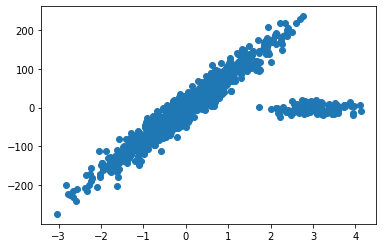

In [32]:
plt.scatter(X, y)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)


In [34]:
lr = linear_model.LinearRegression()
lasso = linear_model.LassoCV(alphas=[0.01, 0.02, 0.1, 0.2, 0.5], random_state=42)
ridge = linear_model.RidgeCV(alphas=[0.01, 0.02, 0.1, 0.2, 0.5])
en = linear_model.ElasticNetCV(alphas=[0.01, 0.02, 0.1, 0.2, 0.5], l1_ratio=[0.01, 0.1, 0.3, 0.5, 0.8, 0.9, 0.99], random_state=42)

lr.fit(X_train, y_train)
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
en.fit(X_train, y_train)

pass

**Linear Regression**

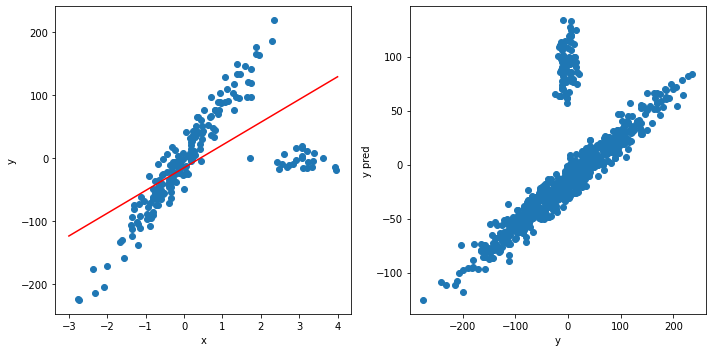

In [35]:
x_fake = np.linspace(-3, 4, 1000).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
ax[0].scatter(X_train, y_train, label="LR")
ax[0].plot(x_fake, lr.predict(x_fake), c="r")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].scatter(y_test, lr.predict(X_test))
ax[1].set_xlabel("y")
ax[1].set_ylabel("y pred")
plt.tight_layout()

**LASSO**

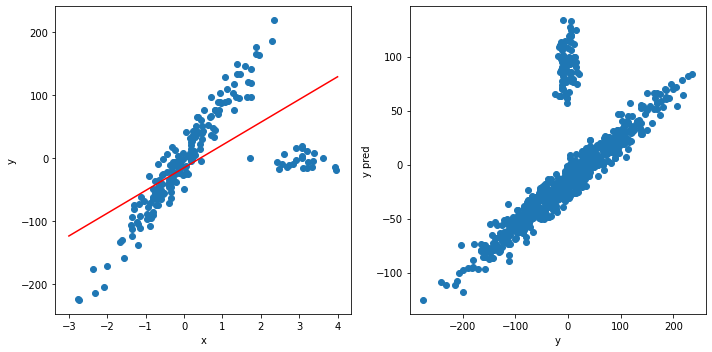

In [36]:
fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
ax[0].scatter(X_train, y_train, label="LR")
ax[0].plot(x_fake, lasso.predict(x_fake), c="r")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].scatter(y_test, lasso.predict(X_test))
ax[1].set_xlabel("y")
ax[1].set_ylabel("y pred")
plt.tight_layout()

**Ridge**

In [37]:
fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
ax[0].scatter(X_train, y_train, label="LR")
ax[0].plot(x_fake, ridge.predict(x_fake), c="r")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].scatter(y_test, ridge.predict(X_test))
ax[1].set_xlabel("y")
ax[1].set_ylabel("y pred")
plt.tight_layout()

**Elastic Net**

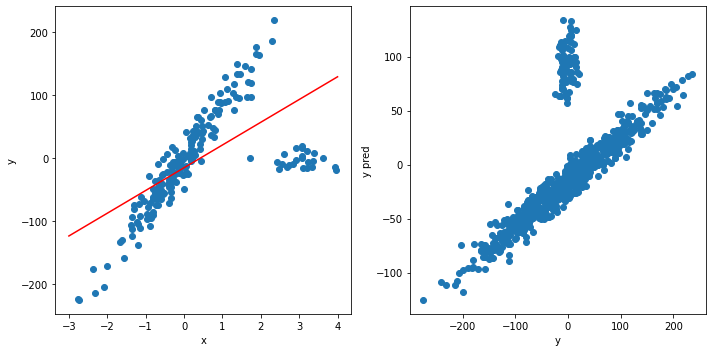

In [38]:
fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
ax[0].scatter(X_train, y_train, label="LR")
ax[0].plot(x_fake, en.predict(x_fake), c="r")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].scatter(y_test, en.predict(X_test))
ax[1].set_xlabel("y")
ax[1].set_ylabel("y pred")
plt.tight_layout()

**Huber Regressor**

Esse é um dos modelos robustos contra outliers disponíveis no `sklearn`. As outras alternativas são:

- `RANSAC`
- `Theil Sen`

O `HuberRegressor` tende a ser mais lento do que as outras alternativas se o número de amostras for muito grande. No entanto, usando os hiper-parâmetros padrão, o `HuberRegressor` normalmente gera os melhores resultados.

In [39]:
huber = linear_model.HuberRegressor()
huber.fit(X_train, y_train)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
               tol=1e-05, warm_start=False)

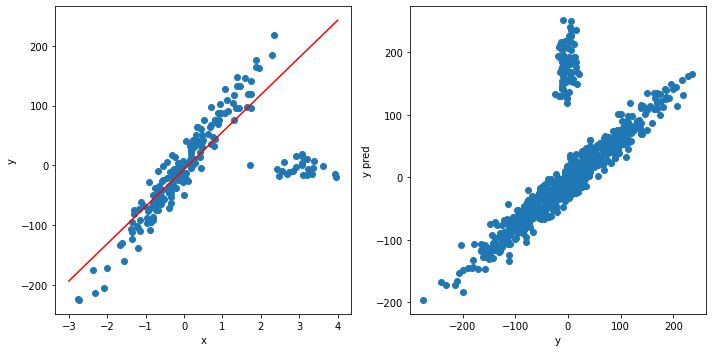

In [40]:
fig, ax = plt.subplots(figsize=(10, 5), ncols=2)
ax[0].scatter(X_train, y_train, label="LR")
ax[0].plot(x_fake, huber.predict(x_fake), c="r")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].scatter(y_test, huber.predict(X_test))
ax[1].set_xlabel("y")
ax[1].set_ylabel("y pred")
plt.tight_layout()

# 3. Aplicação real

Faremos a predição da quantidade de amido no milho através de dados de espectroscopia de infravermelho próximo (NIRS).

Utilizaremos uma base de dados adaptada de [eigenvector](http://www.eigenvector.com/data/Corn/). A base conta com informações de 80 amostras de milho que foram medidas com 3 sensores NIRS entre as frequências de 1100-2498 nm, em intervalos de 2 nm. Assim, a base final conta com 2100 features, 80 amostras e 1 atributo preditivo, que no nosso caso, é a quantidade de amido.


In [41]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
import pandas as pd

# data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/starch_corn.csv')
data = pd.read_csv('starch_corn.csv')
data.head()

m5_wl1100nm  m5_wl1102nm  m5_wl1104nm  ...  mp6_wl2496nm  mp6_wl2498nm  starch
0     0.044495     0.044383     0.044258  ...      0.674679      0.674056  64.838
1     0.046504     0.046349     0.046230  ...      0.682648      0.682164  64.851
2     0.046958     0.046817     0.046663  ...      0.651984      0.651517  63.567
3     0.045461     0.045321     0.045205  ...      0.647153      0.646694  63.263
4     0.053948     0.053786     0.053650  ...      0.718627      0.718106  64.148

[5 rows x 2101 columns]

In [43]:
data.shape

(80, 2101)

In [44]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

Uma primeira tentativa:

In [45]:
lr = linear_model.LinearRegression(normalize=True)
lasso = linear_model.LassoCV(alphas=[0.001, 0.01, 0.02, 0.05, 0.1, 0.2], random_state=1, normalize=True)
ridge = linear_model.RidgeCV(alphas=[0.001, 0.01, 0.02, 0.05, 0.1, 0.2], normalize=True)

lr.fit(X_train, y_train)
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0447060905476064, tolerance: 0.003942569415686275
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0958004167351696, tolerance: 0.003457627682352945
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9242904123985038, tolerance: 0.003728706250980395
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

RidgeCV(alphas=array([0.001, 0.01 , 0.02 , 0.05 , 0.1  , 0.2  ]), cv=None,
        fit_intercept=True, gcv_mode=None, normalize=True, scoring=None,
        store_cv_values=False)

In [46]:
mean_squared_error(y_test, lr.predict(X_test), squared=False), r2_score(y_test, lr.predict(X_test))

(0.22100537190889585, 0.883412370765918)

In [47]:
mean_squared_error(y_test, lasso.predict(X_test), squared=False), r2_score(y_test, lasso.predict(X_test))

(0.44292180629453937, 0.5317250396707567)

Quantos coeficientes não-nulos?

In [48]:
len(lasso.coef_[lasso.coef_ != 0])

132

In [49]:
len(lasso.coef_[lasso.coef_ != 0]) / X_train.shape[1]

0.06285714285714286

In [50]:
mean_squared_error(y_test, ridge.predict(X_test), squared=False), r2_score(y_test, ridge.predict(X_test))

(0.23199175966343868, 0.8715328974586649)

Vamos analisar o comportamento do target para ver se obtemos algum insight que possa nos ajudar.

(array([2., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 3., 2., 1., 1., 0., 0.,
        4., 3., 1., 1., 3., 1., 0., 0., 0., 3., 3., 2., 0., 3., 2., 1., 2.,
        1., 0., 2., 3., 1., 2., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 2., 1., 1., 0., 0., 1., 2., 1.]),
 array([0.612809  , 0.61572783, 0.61864666, 0.62156548, 0.62448431,
        0.62740314, 0.63032197, 0.6332408 , 0.63615963, 0.63907845,
        0.64199728, 0.64491611, 0.64783494, 0.65075377, 0.65367259,
        0.65659142, 0.65951025, 0.66242908, 0.66534791, 0.66826673,
        0.67118556, 0.67410439, 0.67702322, 0.67994205, 0.68286088,
        0.6857797 , 0.68869853, 0.69161736, 0.69453619, 0.69745502,
        0.70037384, 0.70329267, 0.7062115 , 0.70913033, 0.71204916,
        0.71496798, 0.71788681, 0.72080564, 0.72372447, 0.7266433 ,
        0.72956213, 0.73248095, 0.73539978, 0.73831861, 0.74123744,
        0.74415627, 0.74707509, 0.74999392, 0.75291275, 0.75583158,
        0.75875041, 0.76166923

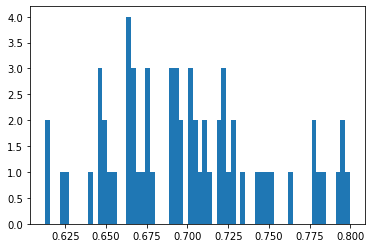

In [51]:
plt.hist(X_train.iloc[:, -1], bins=64)

(array([2., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 2., 3., 1., 0., 1.,
        0., 1., 4., 2., 1., 1., 3., 1., 0., 0., 0., 3., 1., 4., 0., 3., 2.,
        0., 3., 1., 0., 2., 3., 1., 2., 1., 0., 0., 0., 2., 1., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 3., 1., 0., 0., 1., 2., 1.]),
 array([-0.48970197, -0.48554454, -0.48138711, -0.47722967, -0.47307224,
        -0.4689148 , -0.46475737, -0.46059993, -0.4564425 , -0.45228506,
        -0.44812763, -0.44397019, -0.43981276, -0.43565533, -0.43149789,
        -0.42734046, -0.42318302, -0.41902559, -0.41486815, -0.41071072,
        -0.40655328, -0.40239585, -0.39823842, -0.39408098, -0.38992355,
        -0.38576611, -0.38160868, -0.37745124, -0.37329381, -0.36913637,
        -0.36497894, -0.36082151, -0.35666407, -0.35250664, -0.3483492 ,
        -0.34419177, -0.34003433, -0.3358769 , -0.33171946, -0.32756203,
        -0.3234046 , -0.31924716, -0.31508973, -0.31093229, -0.30677486,
        -0.30261742, -0.29845999, -0.29430255, -0.290

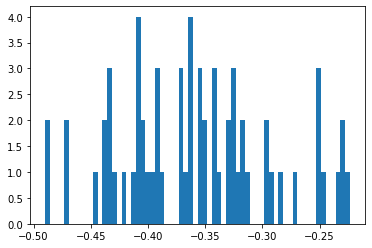

In [52]:
plt.hist(np.log(X_train.iloc[:, -1]), bins=64)

In [53]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=50, random_state=42),
    TransformedTargetRegressor(
      regressor=linear_model.LinearRegression(),
      func=np.log,
      inverse_func=np.exp
  )
)
pipe.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=50,
                     random_state=42, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(check_inverse=True,
                                            func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression(copy_X=True,
                                                                       fit_intercept=True,
                                                                       n_jobs=None,
                                                                       normalize=False),
                                            transformer=None))],
        

In [54]:
mean_squared_error(y_test, pipe.predict(X_test), squared=False), r2_score(y_test, pipe.predict(X_test))

(0.20456884091120672, 0.9001091336110356)

# Bônus

Nunca subestime um bom e velho modelo linear. Muitas vezes somos tentados a pular etapas e querer logo buscar alternativas mais "poderosas".

Eu gostaria de deixar alguns pontos objetivos (e pessoais) do porquê modelos lineares deveriam ter um local especial em nossos corações.

**Objetivamente falando:**

- São a base, ou partes constituintes, de diversas soluções de AM
    * Deep Learning, SVMs, Árvores de Regressão, etc.
    * SGD is everywhere
- São fáceis de implementar, interpretar, utilizar em produção 

**Minha experiência pessoal**

- Quanto mais tenho contato com AM, mas eu percebo que, no fundo, no fundo, quase tudo se resume a:
    * Regressão linear
    * Busca por vizinhos mais próximos
    * Dividir para conquistar (árvores de decisão)
- Junte esses ingredientes e adicione um pouco de _kernel_, um pouco de teoria das probabilidades e pronto: grande parte dos algoritmos de AM podem ser entendidos a partir desses componentes

**E se isso ainda não é o suficiente...**

Eu deixo essa [ótima apresentação](https://www.youtube.com/watch?v=68ABAU_V8qI) do Vincent Warmerdam, onde ele demonstra o poder (e eu estou falando de poder preditivo) dos modelos lineares.